
Install all packages for the tutorial.

In [1]:
!pip install scanpy umap-learn anndata numpy scipy pandas matplotlib scrublet seaborn python-igraph louvain leidenalg

     |████████████████████████████████| 2.0MB 4.4MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 133kB 18.2MB/s 
     |████████████████████████████████| 3.2MB 20.6MB/s 
     |████████████████████████████████| 2.2MB 41.2MB/s 
     |████████████████████████████████| 1.4MB 21.7MB/s 
     |████████████████████████████████| 1.1MB 23.5MB/s 
     |████████████████████████████████| 655kB 30.1MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=78fd07a80f625313d0620ed903f05c473f208e28470d2f7bd678675da5d479cc
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for sinfo: filename=sinfo-0.3.4-cp37-none-any.whl size=7899 sha256=7b0cac7824cbbba5672a50aaf375b72d8e4ff2eb3363993cceed83ab12bec8dd
  Stored in directory: /root/.cache/pip/wheels/43/a4/e5/d4e0a170ccc134e509ea55acad7845f

Load all required packages.

In [2]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

#pretty plotting
import seaborn as sb



In [4]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                         7.1.2
astor                       0.8.1
bottleneck                  1.3.2
cached_property             1.5.2
certifi                     2021.05.30
cffi                        1.14.5
chardet                     3.0.4
cloudpickle                 1.3.0
cycler                      0.10.0
cython_runtime              NA
dask                        2.12.0
dateutil                    2.8.1
debugpy                     1.0.0
de

Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all seaborn plots. You can set the context as well to 'talk' or 'paper'.

In [5]:
sb.set_context(context='poster')


# Read data

The dataset consists of 3k PBMCs (Human) provided by 10X Genomics. The data is one of the built-in datasets that can be directly loaded with scanpy.     

In [6]:
adata = sc.datasets.pbmc3k()

try downloading from url
http://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


Let us check the dataset size. 

In [7]:
adata.shape

(2700, 32738)

In [8]:
print('Total number of observations: {:d}'.format(adata.n_obs))

Total number of observations: 2700


# Pre-processing and visualization

## Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

`Scanpy` provides the `calculate_qc_metrics` function, which computes the following QC metrics:
On the cell level (`.obs` level):
* `n_genes_by_counts`: Number of genes with positive counts in a cell
* `log1p_n_genes_by_counts`: Log(n+1) transformed number of genes with positive counts in a cell
* `total_counts`: Total number of counts for a cell
* `log1p_total_counts`: Log(n+1) transformed total number of counts for a cell
* `pct_counts_in_top_50_genes`: Cumulative percentage of counts for 50 most expressed genes in a cell
* `pct_counts_in_top_100_genes`: Cumulative percentage of counts for 100 most expressed genes in a cell
* `pct_counts_in_top_200_genes`: Cumulative percentage of counts for 200 most expressed genes in a cell
* `pct_counts_in_top_500_genes`: Cumulative percentage of counts for 500 most expressed genes in a cell

On the gene level (`.var` level):
* `n_cells_by_counts`: Number of cells this expression is measured in
* `mean_counts`: Mean expression over all cells
* `log1p_mean_counts`: Log(n+1) transformed mean expression over all cells
* `pct_dropout_by_counts`: Percentage of cells this feature does not appear in
* `total_counts`: Sum of counts for a gene
* `log1p_total_counts`: Log(n+1) transformed sum of counts for a gene

In [9]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Lastly, let us compute the fraction of mitochondrial reads. 
**Note**: mitochondrial genes in human start with 'MT-'

In [10]:
mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['total_counts']

Let us visualize the number of expressed genes and the number of counts as a scatter plot. 

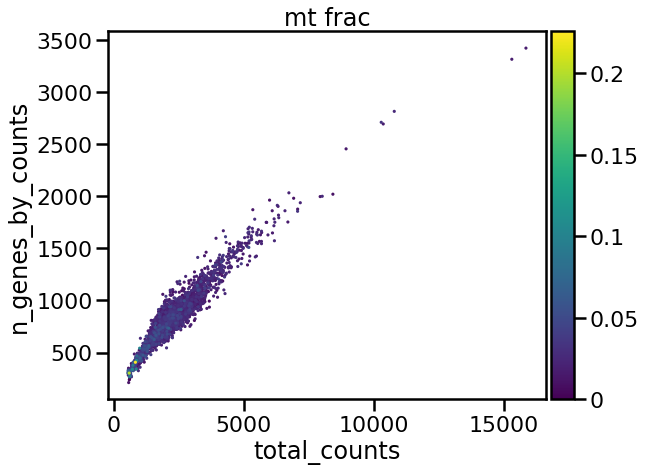

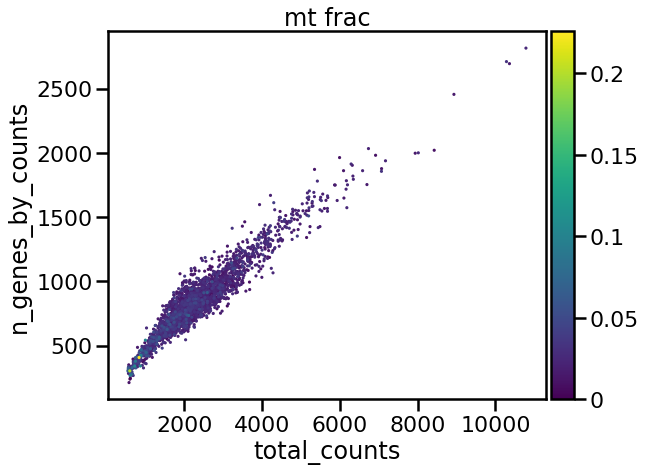

In [11]:
#Data quality summary plots
rcParams['figure.figsize']=(7,7)
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='mt_frac', size=40)
p2 = sc.pl.scatter(adata[adata.obs['total_counts']<15000], 'total_counts', 'n_genes_by_counts', 
                   color='mt_frac', size=40)

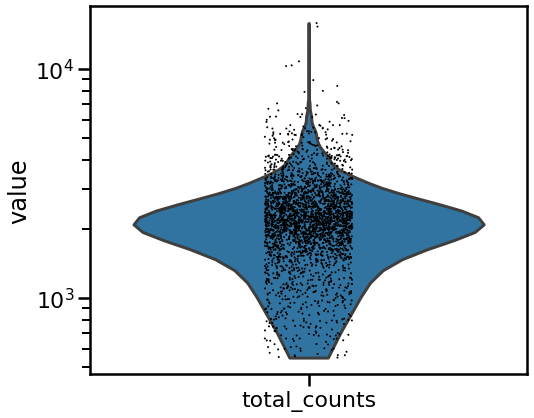

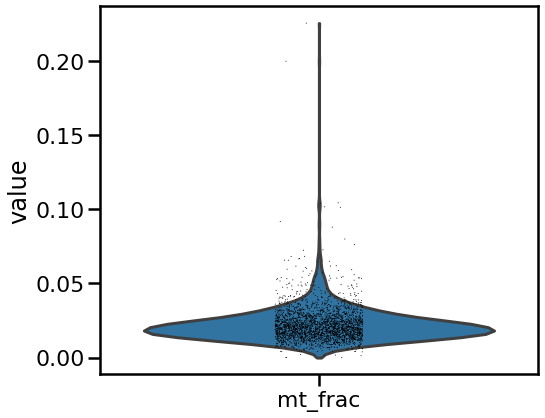

In [12]:
#Sample quality plots
rcParams['figure.figsize']=(7,7) #set figure size
t1 = sc.pl.violin(adata, 'total_counts',
                  #groupby='sample',
                  size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')

Examine the overall library complexity. 
Let us plot the top 20 highest expressed genes first.

normalizing counts per cell
    finished (0:00:00)


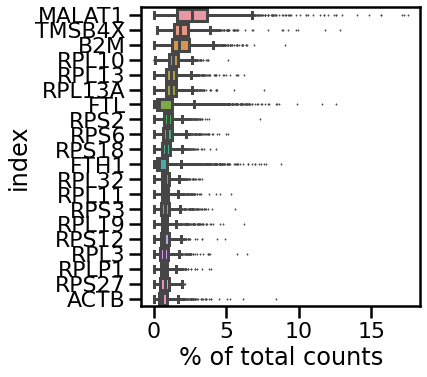

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20)

We expect to see the “usual suspects”, i.e., mitochondrial genes, actin, ribosomal protein, MALAT1. 

How many counts come from the top 50/100/200/500 highest expressed genes? Visualize the fraction as violin plot.

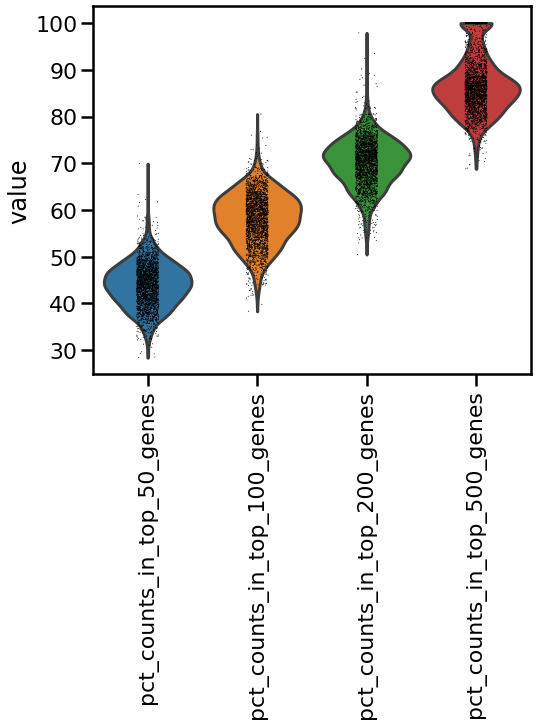

In [14]:
#Sample quality plots
rcParams['figure.figsize']=(7,7) #set figure size
t3 = sc.pl.violin(adata, keys=['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 
                     'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
                    ], rotation = 90)

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly.  We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.

Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

Create a histogram for the total number of counts. Further, create a histogram for the low count and high count regime, each.

Note: `pandas` does some histogram plotting with `adata.obs['n_counts'].hist()`, howecer, you will obtain prettier plots with `distplot` from `seaborn`.    

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

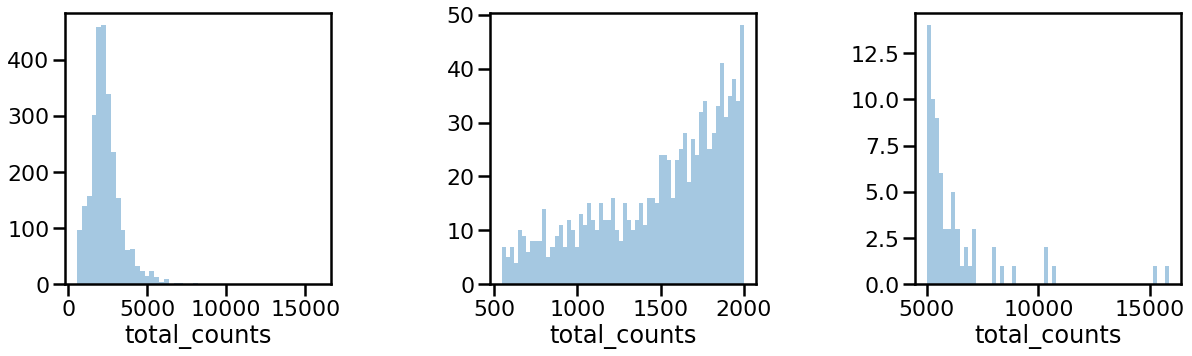

In [15]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['total_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<2000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']>5000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

Histograms of the number of counts per cell show a small group of cells with fewer than 700 counts, which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts with decaying slope at 5,000 counts. We estimate this population to range until 10,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

Create a histogram for the total number of genes. Further, create a histogram for the low gene count and high gene count regime, each.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


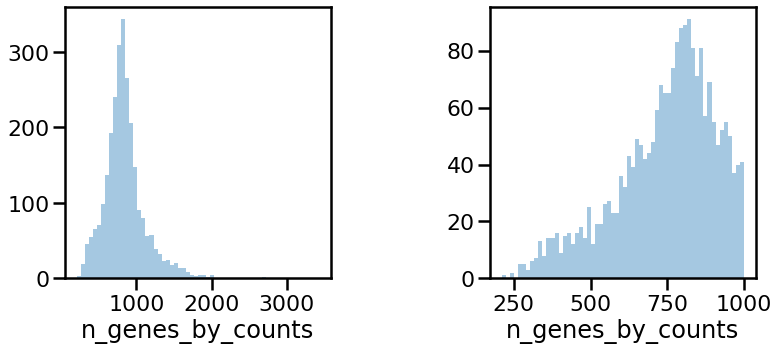

In [16]:
#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1000], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 500 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

Create a histogram for the fraction of mitochondrial genes. Further, create a histogram for the high fraction regime, each.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


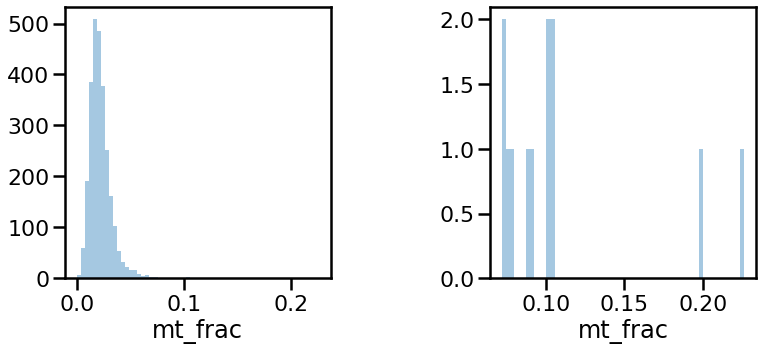

In [17]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.07], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [18]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 700)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 10000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.1]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 2700
filtered out 43 cells that have less than 700 counts
Number of cells after min count filter: 2657
filtered out 5 cells that have more than 10000 counts
Number of cells after max count filter: 2652
Number of cells after MT filter: 2647
filtered out 171 cells that have less than 500 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 2476


Next, filter out non-expressed genes. Check the number of remaining genes after filtering.

In [19]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 32738
filtered out 23145 genes that are detected in less than 20 cells
Number of genes after cell filter: 9593


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset.

### Summarize sample information

In order to group by `batch` (for future purposes, because we presently deal with one sample), let us add a `batch` covariate to the `adata` object. 

In [20]:
adata.obs['batch'] = '1'

df = adata.obs[['n_genes_by_counts','total_counts', 'batch']]
df_all = pd.DataFrame(df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).values,
                      index=df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='batch')['n_genes_by_counts'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='batch')['total_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='batch')['total_counts'].apply(np.median).values
df_all

,mean_genes,median_genes,mean_counts,median_counts
batch,,,,
1,881.600969,833.0,2477.311035,2265.5


## Normalization

So far, our dataset is a count matrix. Here, every count corresponds to an mRNA molecule captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Several methods for normalization for scRNA-seq data have been proposed. Ideally, we want to apply the `scran` library size normalization followed by log-transformation. However, `scran` is again an R package, and we use the simpler normalisation to logCPM, `i.e.` we divide by the library size followed by the log-transformation. In addition, we save the count matrix to `layers` as 'counts'.

**Comment:** For `scran`, we have not (comprehensively) tested whether normalisation per sample or all samples jointly gives more accurate results. When we normalised per sample, observed many more differentially expressed genes across conditions (in the range of thousands). We think that normalisation per sample preserves a systematic bias while joint normalisation removes batch effects within the same cluster partially, if a cluster contains cell from several batches. No such effect of the normalisation can be observed when samples do not overlap at all. For the time being, we perform joint normalisation of all samples. 

In [21]:
adata.layers['counts'] = adata.X.copy()

We use the logCPM normalisation: Normalise with the library size and log-scale.

In [22]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


... storing 'batch' as categorical


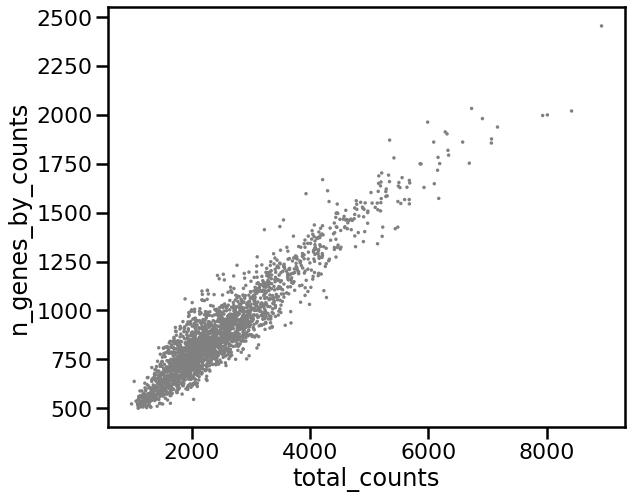

In [23]:
# Visualize the estimated size factors
rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata,  'total_counts', 'n_genes_by_counts')


## Batch correction - general remarks

This dataset consists of a single batch, thus, batch effect correction is not an issue here. If you handle several batches, you may observe differences across samples, for instance, in the library size per dataset. Such differences may contribute to the batch effect. [Büttner et al., Nat Meth (2019)](https://www.nature.com/articles/s41592-018-0254-1) compared the performance of several batch correction methods. For low-to-medium complexity datasets, ComBat performed best among the tested tools. ComBat is also available in `scanpy` (see `sc.pp.combat`). 

For high complexity data, especially when you encounter changes in cell type composition, consider to use a data integration method of your choice. We distinguish three different types, *i.e.* if the methods create a corrected data matrix (in feature space), an embedding or a knn-graph. Examples are:
1. feature space: MNN (`scanpy.external.pp.mnn_correct`), scanorama (integrates with scanpy), Seurat v3 (R based)
2. embedding: scVI (Python based), Harmony (R based), scanorama
3. knn-graph: conos (R based), BBKNN (`scanpy.external.pp.bbknn`)

Several benchmarking studies aimed to determine best performing methods. In simple cases, Seurat v3 and Harmony performed best [Tran et al., Genome Biology (2020)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9) and [Chazarra-Gil et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111211v2). More complex scenarios have been benchmarked in [Luecken et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2), where BBKNN, Scanorama, and scVI performed well. Furthermore, Scanorama had high scores in the preservation of biological signals, while BBKNN tended to overcorrect. Moreover, Luecken et al. tested different pre-processing schemes. In general, **selecting highly variable genes prior to batch correction improved the batch effect correction result**. We continue with the selection of highly variable genes. 


## Feature selection (Highly variable genes)

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software *CellRanger*. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

Compute highly variable genes and visualize.

In [24]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


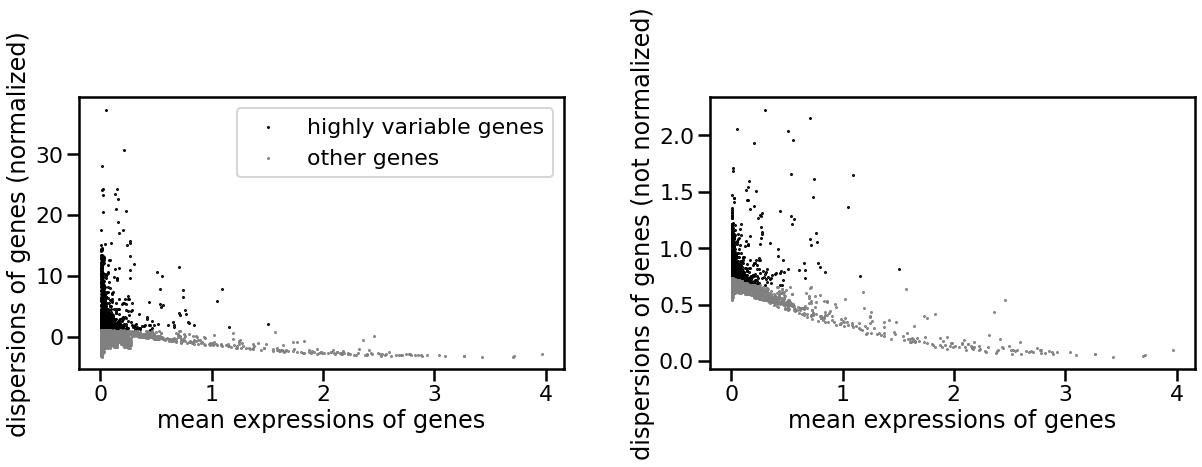

In [25]:
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the `adata.var['highly_variable']` field. The dataset now contains:

* count data as layer 'counts' in adata
* log-CPM normalized data in adata.X
* highly variable gene annotations in `adata.var['highly_variable']`


## Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

We will look at several visualizations to decide which visualization best represents the aspect of the data.

Compute the following embeddings: PCA, t-SNE, UMAP, diffusion map and force-directed graph. Please compute PCA first and compute nearest neighbors next. All other embeddings rely on this information. Visualize the embeddings and color by the total number of counts.

In [26]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


To determine the number of informative principal components, let us review the variance contribution of each component. 

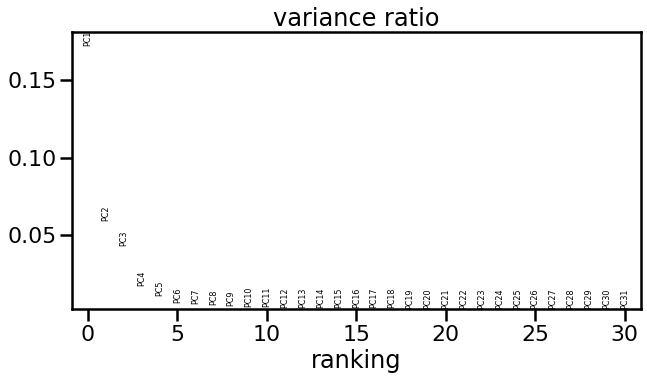

In [27]:
sc.pl.pca_variance_ratio(adata)

Using the elbow method, we select the first 10 PCs as informative.

In [28]:
sc.pp.pca(adata, n_comps=10, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.tsne(adata) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99986875 0.99762106 0.9953837  0.9914239  0.98240227
     0.9736394  0.9621957  0.9575379  0.9521935  0.9412267  0.9217103
     0.9154681  0.9133779  0.90277046]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.

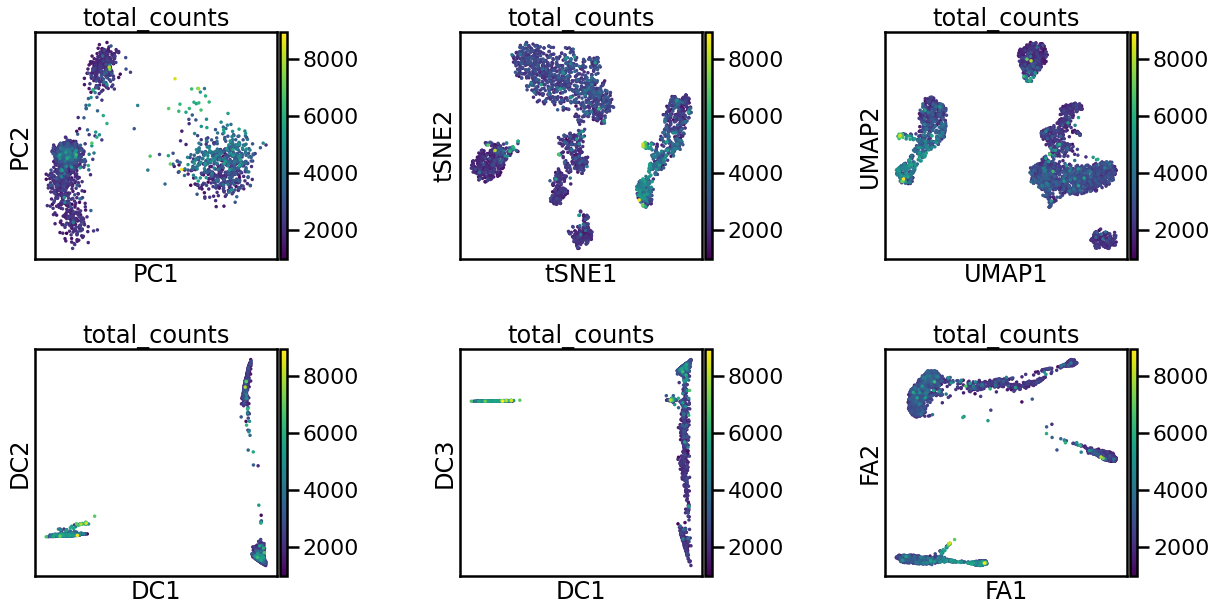

In [29]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='total_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='total_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='total_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
p13 = sc.pl.diffmap(adata, color='total_counts', components=['1,2'], ax=fig.add_subplot(fig_ind[3]),show=False)
p14 = sc.pl.diffmap(adata, color='total_counts', components=['1,3'], ax=fig.add_subplot(fig_ind[4]), show=False)
p15 = sc.pl.draw_graph(adata, color='total_counts', ax=fig.add_subplot(fig_ind[5]), show=False)

plt.show()

**PCA**:

* Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
* The plot shows a weak clustering of the data in two dimensions

**t-SNE**:

* Shows several distinct clusters with clear subcluster structure
* Connections between clusters are difficult to interpret visually

**UMAP**:

* Data points are spread out on the plot showing several clusters
* Connections between clusters also not visible (and not expected for PBMC data)

**Diffusion Maps**:

* Shows regions of higher density and a few disconnected cells in between
* Trajectories not visible (and not expected for PBMC data)
* Each diffusion component extracts heterogeneity in a different part of the data

**Graph**:

* Shows several clusters with substructure
* Lack of trajectories as expected

The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute. UMAP has furthermore been shown to more accurately display the structure in the data.

At this point of the analysis, we have reached an important milestone as we finished the pre-processing and enter the downstream analysis part. **Ideally, we don't have to revisit this part again.**

# Downstream analysis

## Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section).

Compute a `louvain` clustering with two different resolutions (`0.5` and `1.5`). Compare the clusterings in a table and visualize the clustering in an embedding. Optional: Compute a clustering with the `leiden` algorithm. 

In [30]:
# Perform clustering - using highly variable genes
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5')

running Leiden clustering
    finished: found 13 clusters and added
    'leiden_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [31]:
pd.crosstab(adata.obs['leiden_r0.5'], adata.obs['leiden_r1.5'])

leiden_r1.5,0,1,2,3,4,5,6,7,8,9,10,11,12
leiden_r0.5,,,,,,,,,,,,,
0,0,0,295,0,247,1,0,86,0,0,0,0,0
1,0,0,0,255,0,0,0,0,0,0,111,67,10
2,320,0,12,0,0,6,0,66,0,0,0,0,0
3,0,313,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,215,0,0,0,0,0,0,0
5,0,0,0,0,0,0,156,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,149,0,1,0,0
7,0,0,0,0,0,0,0,0,0,144,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,22


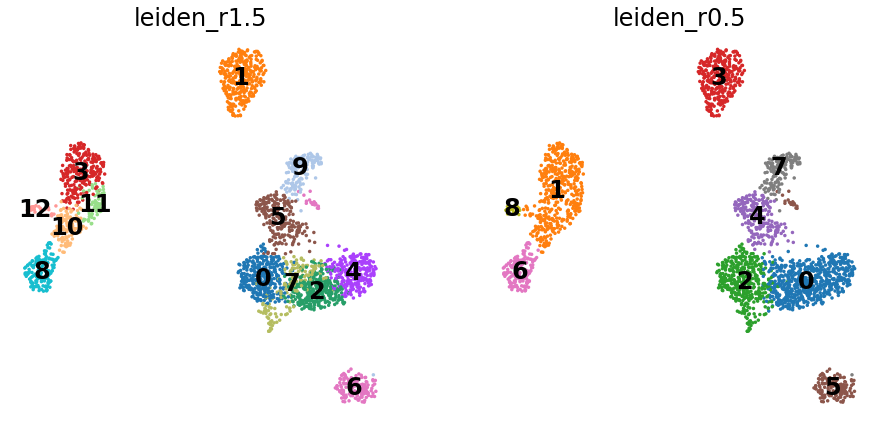

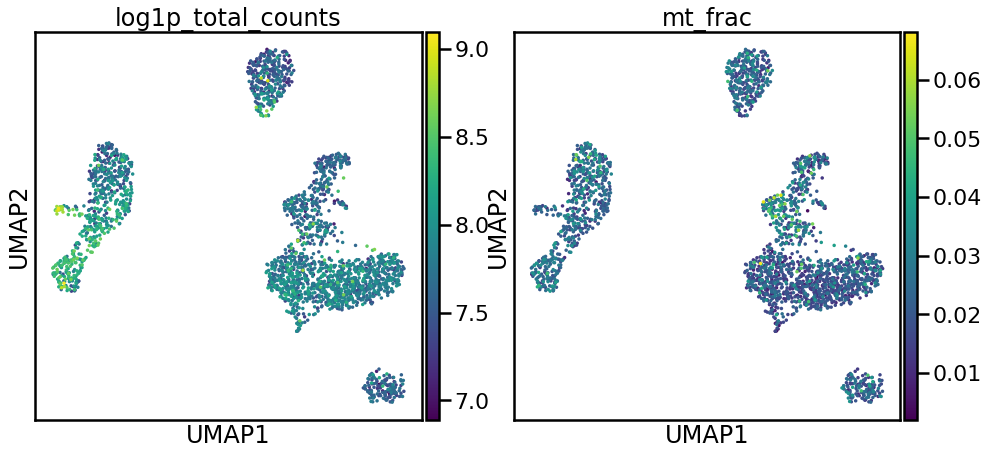

In [45]:
#Visualize the clustering and how this is reflected by different technical covariates
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata, color=['leiden_r1.5', 'leiden_r0.5'],
           legend_loc='on data',  frameon=False)
sc.pl.umap(adata, color=['log1p_total_counts', 'mt_frac'])

## Marker genes and cluster annotation 

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a *Welch t-test with overestimated variance* to be conservative. This is the default in `scanpy`. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

As we are using the relevant mouse gut atlas from the literature in this case study, there is no other reference atlas which we use to annotate the cells by automated annotation. Thus, we do not use scmap or garnett here.

Compute the differential expression profile for each cluster with `rank_genes_groups` and visualize the results.

In [33]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


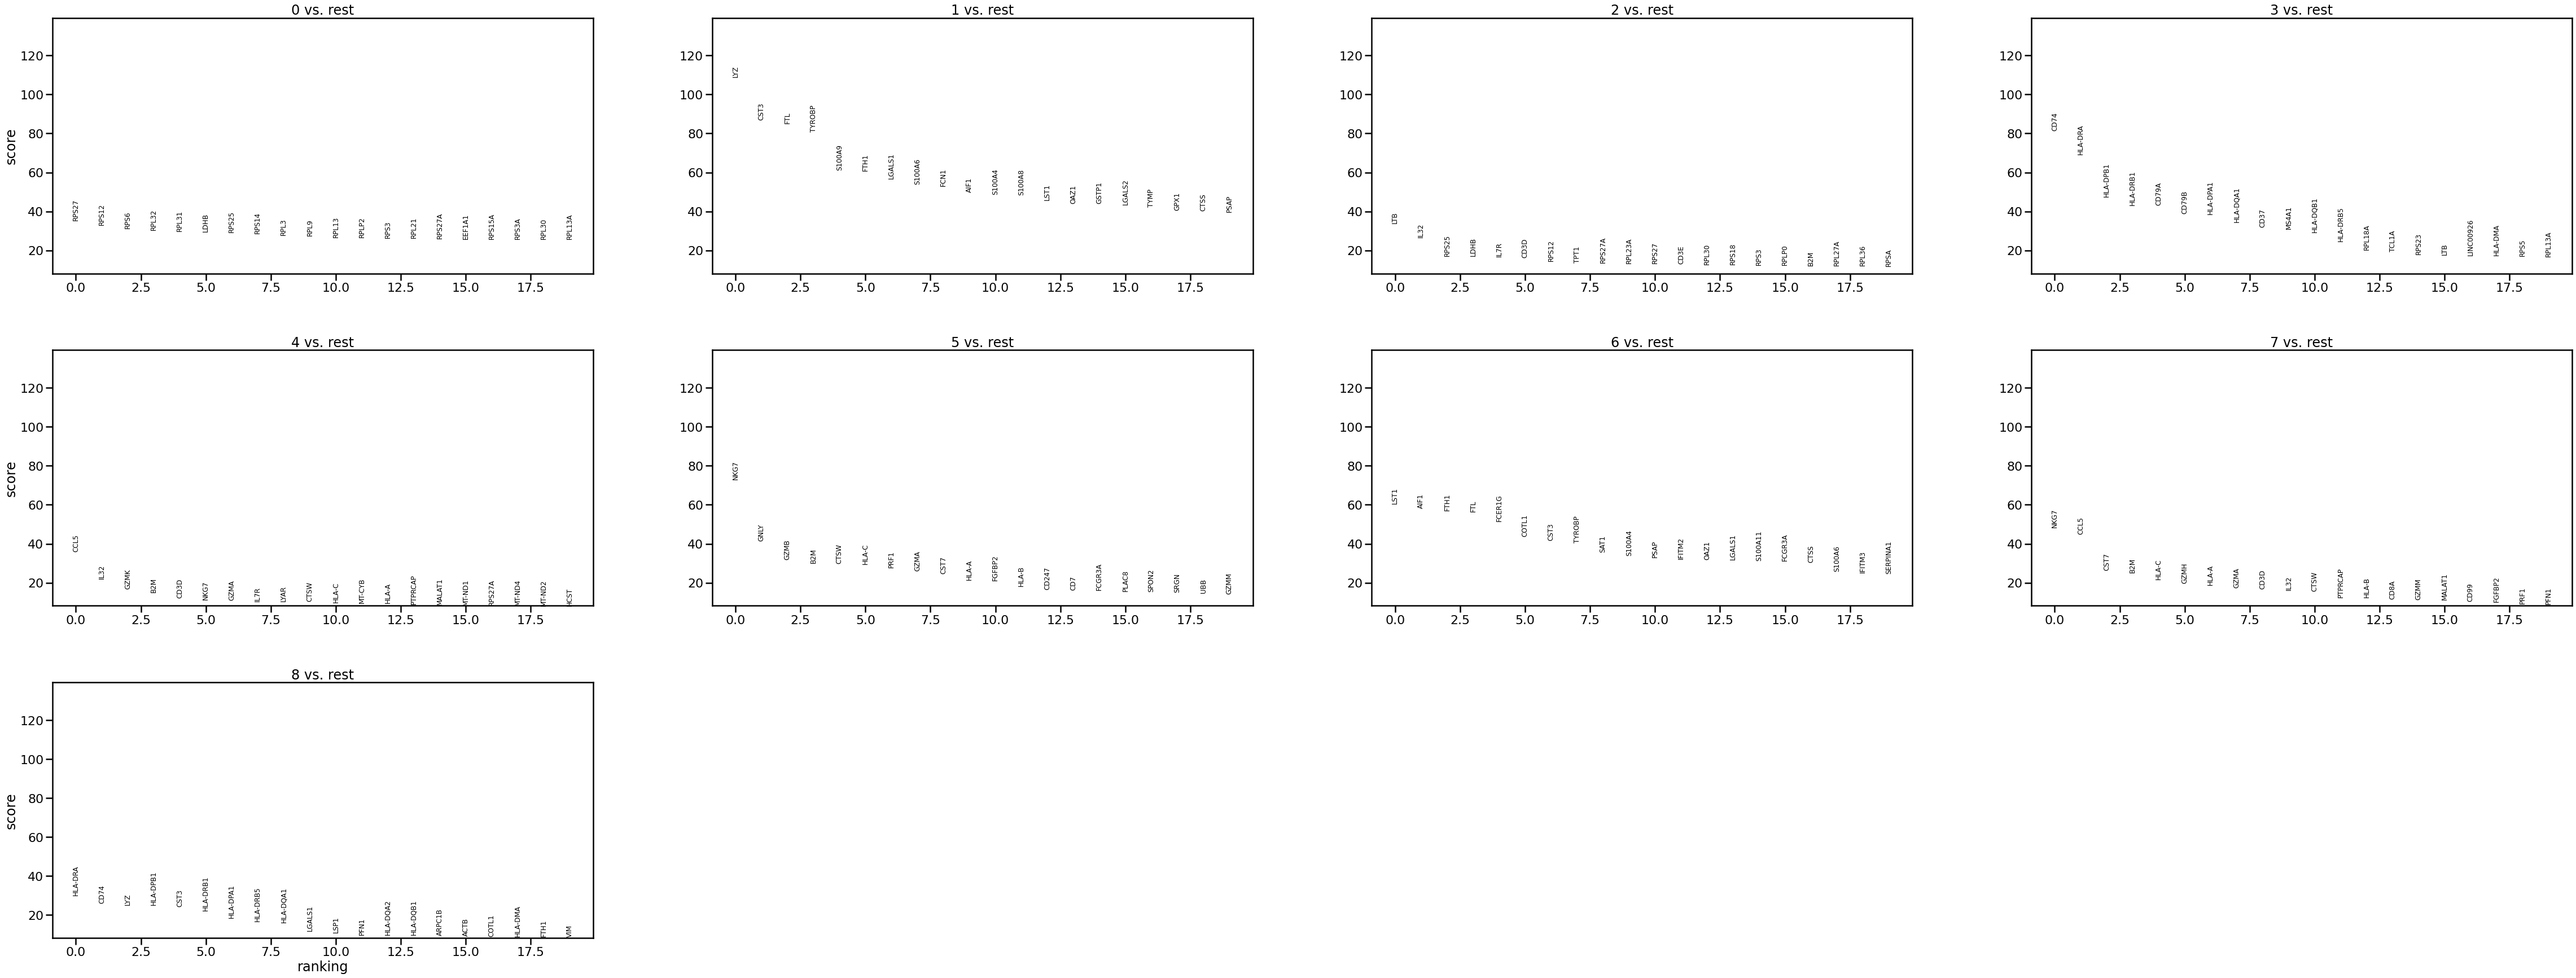

In [34]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12)

In [35]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r1.5', key_added='rank_genes_r1.5')

ranking genes
    finished: added to `.uns['rank_genes_r1.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


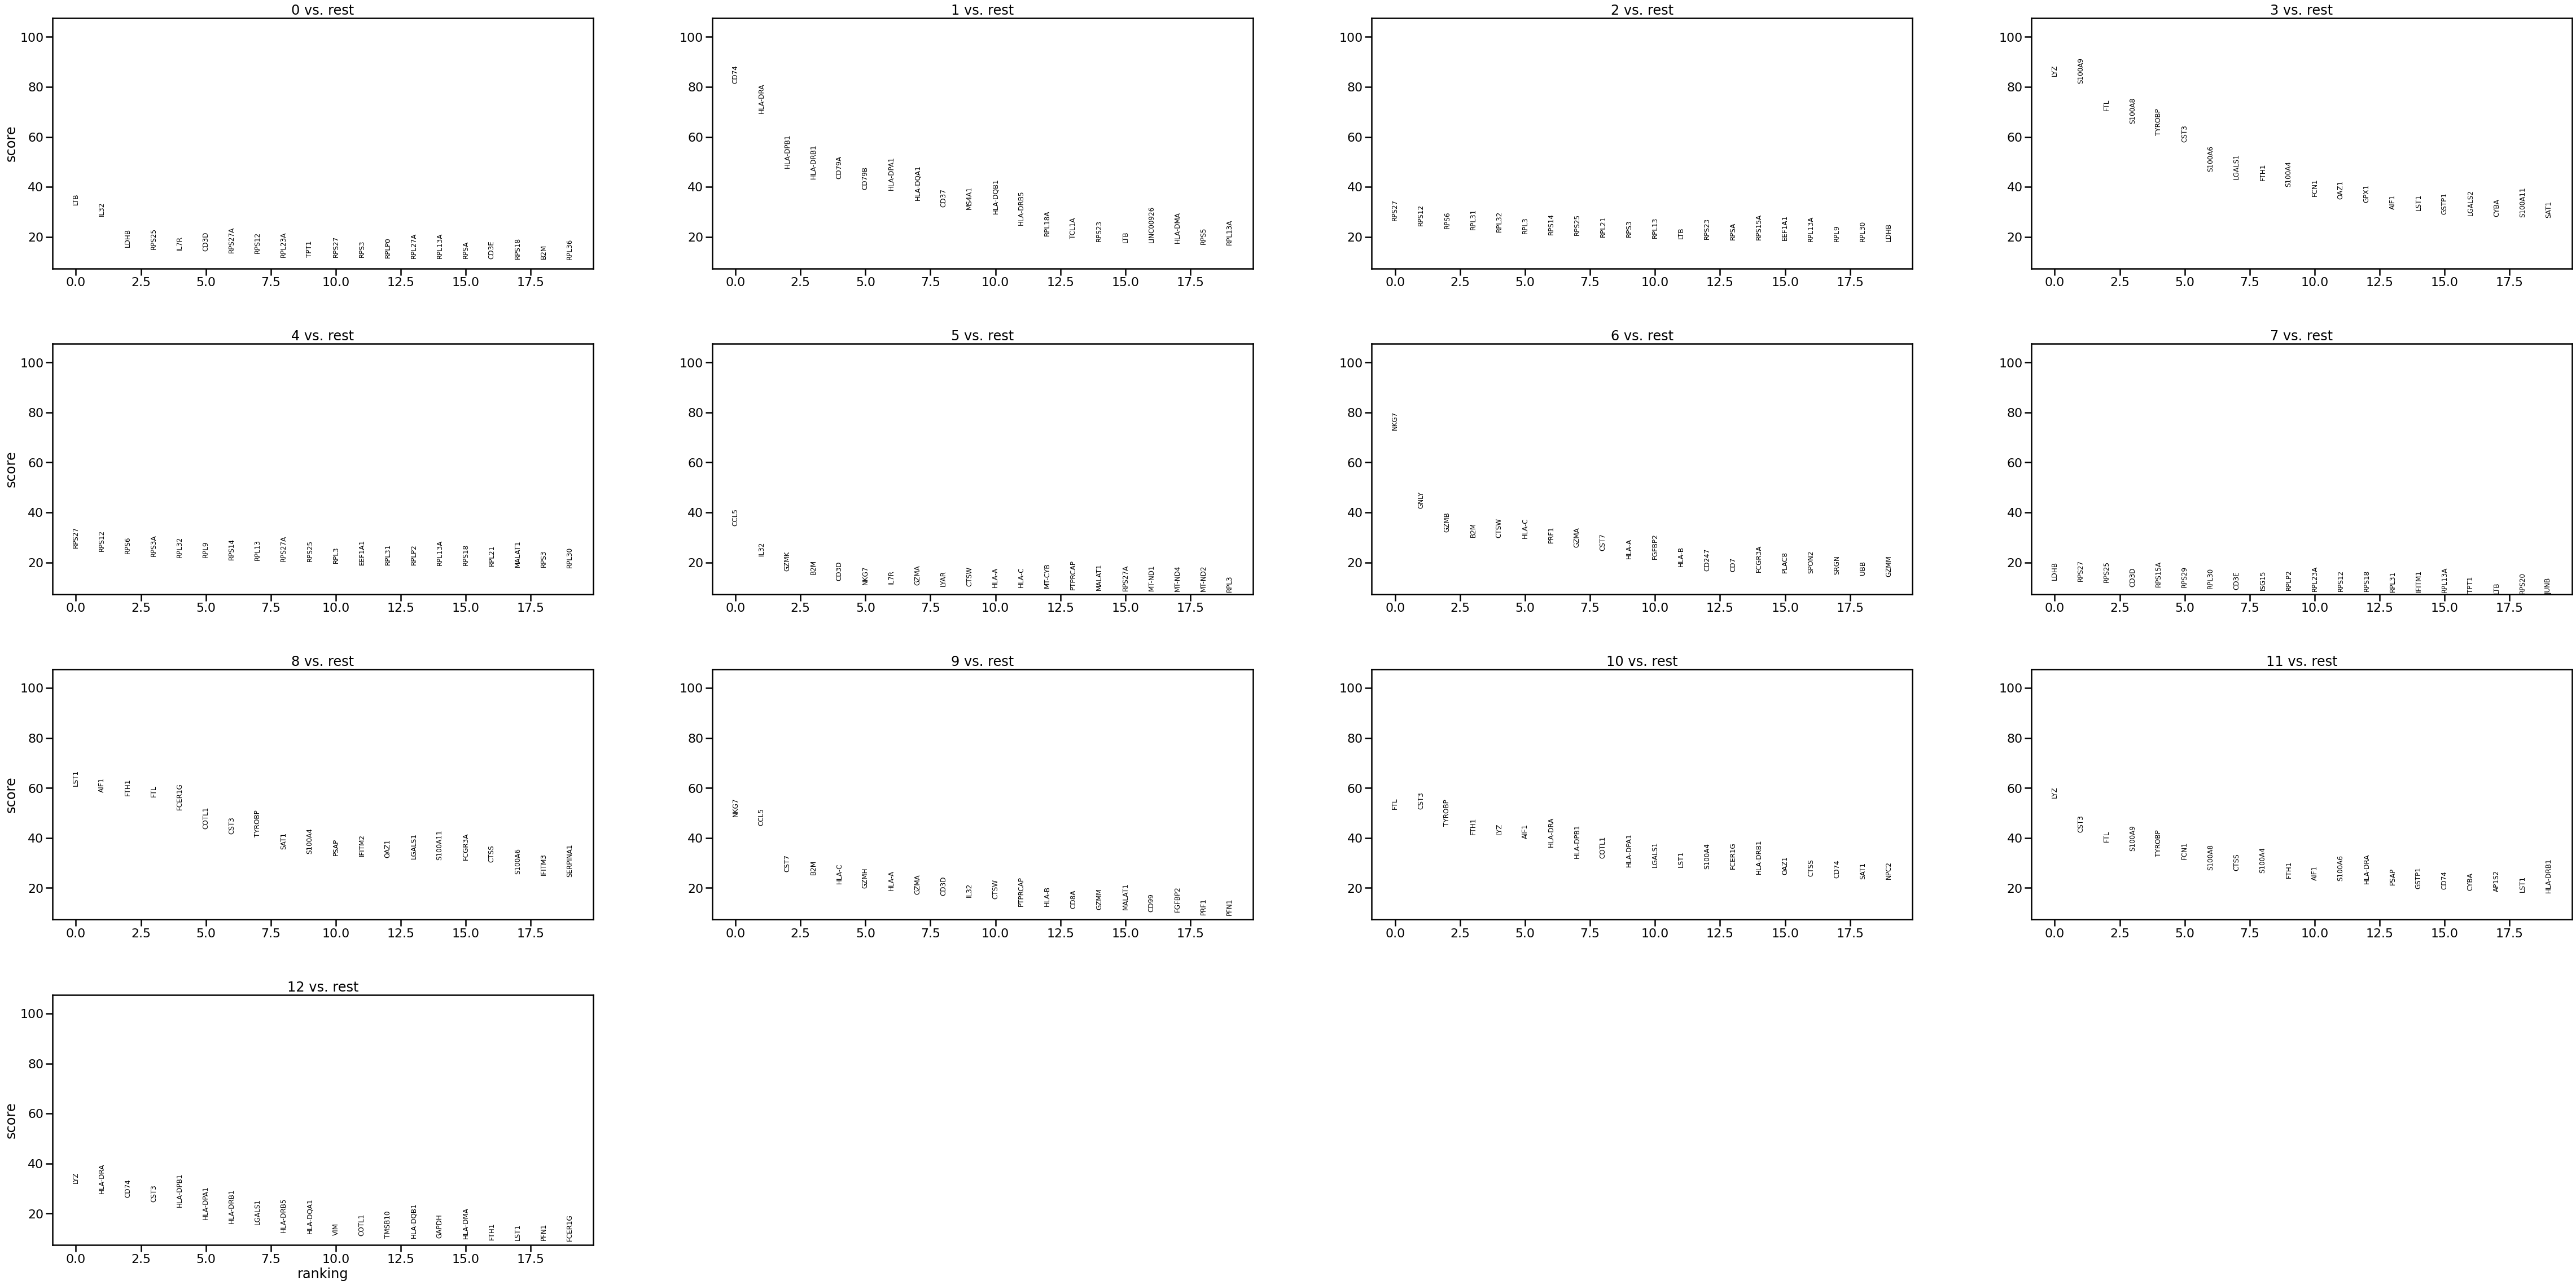

In [36]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1.5', fontsize=12)

Here, we observe a considerable ribosomal proteins (*RPL* and *RPS*), which are part of the ribosomes. Thus, they are involved in mRNA translational processes. Usually, these genes are difficult to interpret.

When it comes to cluster annotation, we have to tap into prior knowledge of the cell type. Depending on the data set, this may involve extensive literature search. In the case of PBMCs, we may refer to several studies and single-cell RNA-sequencing data analysis tutorials to extract marker gene sets. 

The following list is extracted from the Seurat tutorial on PBMCs.


|Marker Gene|Cell Type|
|---------|-------|
|IL7R|CD4 T cells|
|CD14, LYZ|CD14+ Monocytes|
|MS4A1|B cells|
|CD8A|CD8 T cells|
|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|GNLY, NKG7|NK cells|
|FCER1A, CST3|Dendritic Cells|
|PPBP|Megakaryocytes|


Let us define a list of marker genes from literature.

In [37]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

For this demo session, we skip the annotation of the clusters. Let us review several ways to visualise the data with plots like `matrixplot`, `dotplot`,`heatmap` or `violin` plots or coloring an embedding by the marker genes.

Let us check if the marker genes are expressed in our dataset.

In [38]:
np.in1d(marker_genes, adata.var_names)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

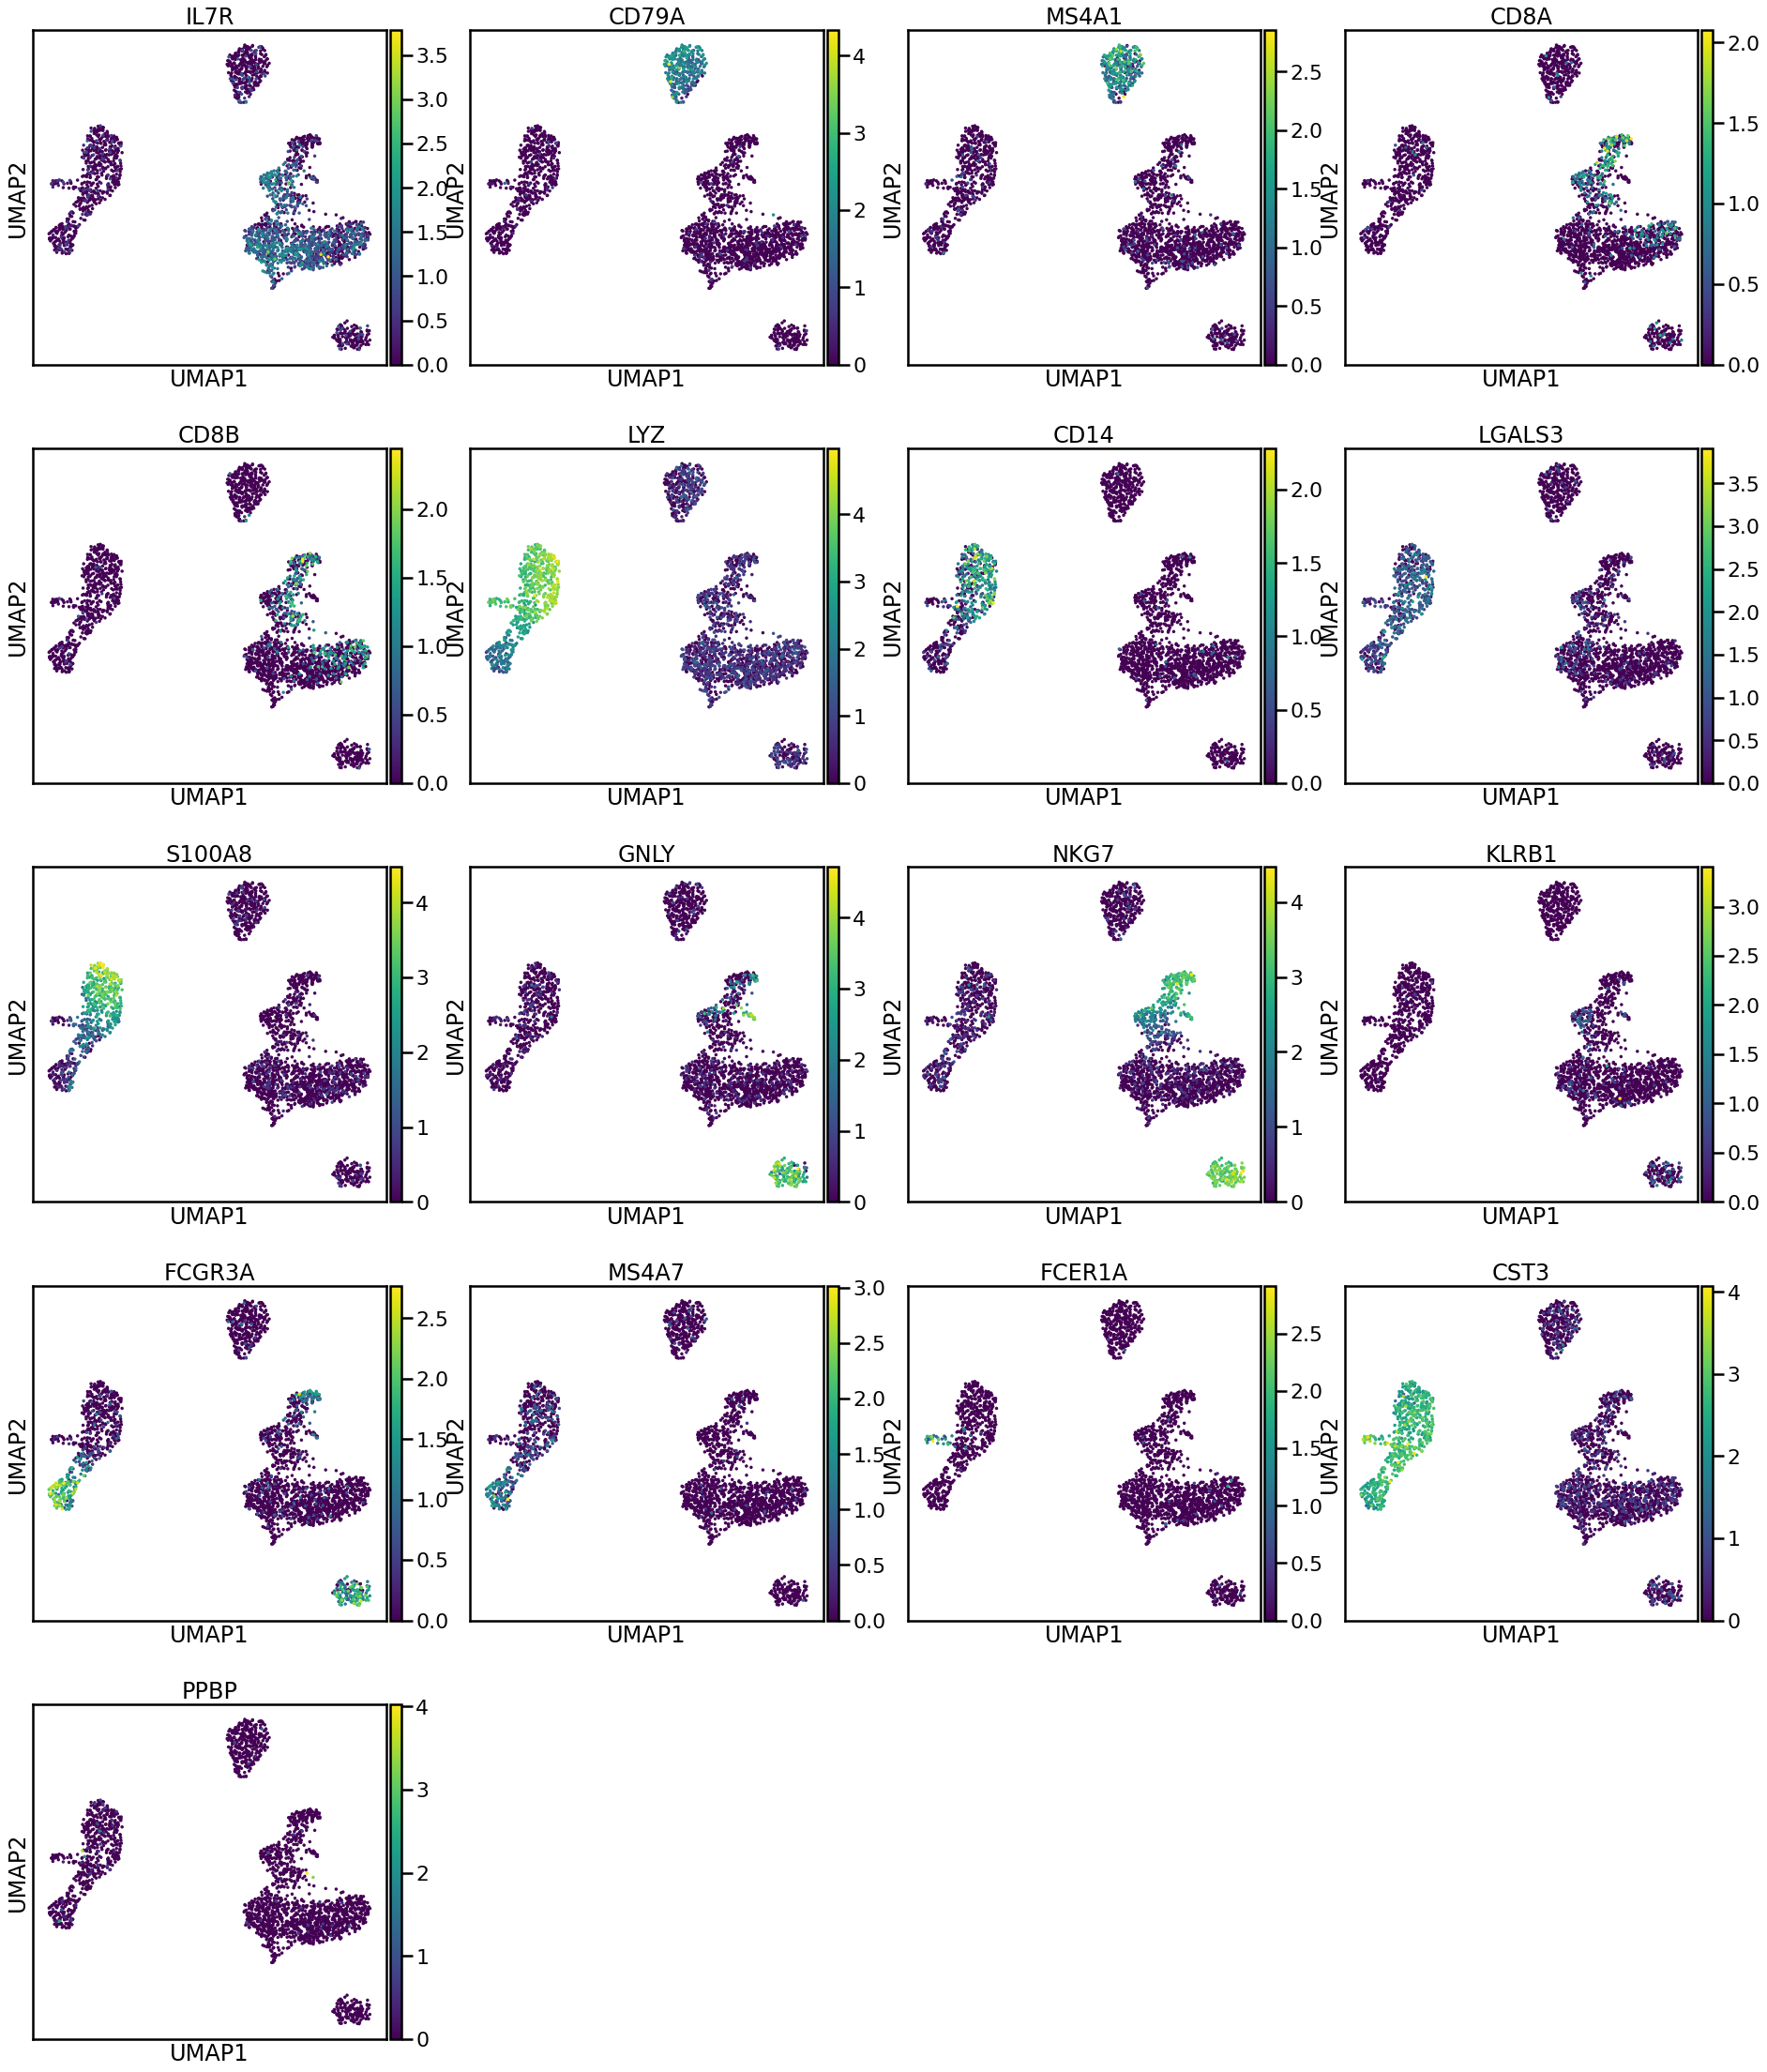

In [46]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata=adata, color=marker_genes, use_raw=False)

In [50]:
sb.set_context(context='paper')

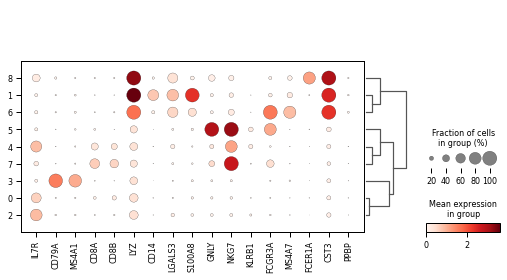

In [51]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden_r0.5', dendrogram=True)

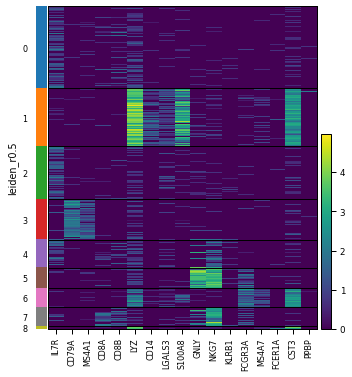

In [52]:
sc.pl.heatmap(adata=adata, var_names=marker_genes,
              groupby='leiden_r0.5', vmin=0)

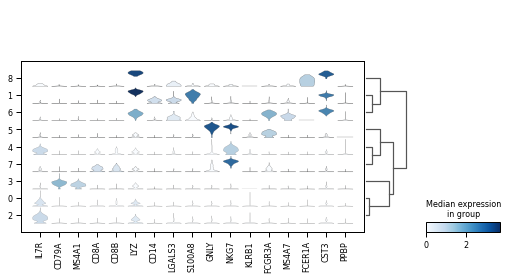

In [54]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden_r0.5', dendrogram=True)

# Save data to file

In [43]:
adata.write('data_processed.h5ad')